## Spatio-Temporal Deep Learning for FacePad

Step 1: Custom Data Loader with Augmentation

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

num_classes =2

In [5]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
import random
from PIL import Image

class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=16, is_train=False):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['attack', 'real']
        self.samples = self._load_samples()
        self.num_frames = num_frames
        self.is_train = is_train  # Flag to check if the dataset is for training

    def _load_samples(self):
        samples = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.endswith('.mp4'):
                    samples.append((os.path.join(cls_dir, fname), self.classes.index(cls)))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = self._load_frames(video_path, self.num_frames)
        
        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        # Apply augmentation if training
        if self.is_train:
            angle = 0
            scale = 0
            # if random.random() > 0.5:
            #     angle = random.uniform(-180, 180)  # Random rotation between -180 to 180 degrees
            # if random.random() > 0.5:
            #     scale = random.uniform(0.7, 1.3)  # Random zoom between 70% to 130%
            frames = [self.apply_augmentation(frame, angle, scale) for frame in frames]
        
        frames = torch.stack(frames)
        return frames, label

    def _load_frames(self, video_path, num_frames):
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Ensure the number of frames to load doesn't exceed the total number of frames in the video
        if self.is_train:
            start_frame = np.random.randint(0, max(1, total_frames - num_frames + 1))
        else:
            start_frame = 0
        
        frames = []
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        
        for _ in range(num_frames):
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(TF.to_tensor(frame))
        
        cap.release()
        
        # If there are not enough frames, repeat the last frame
        while len(frames) < num_frames:
            frames.append(frames[-1])
        
        return frames

    def apply_augmentation(self, image, angle, scale):
        """Apply random augmentations to the image for the training phase."""
        # if random.random() > 0.5:
        #     angle = random.uniform(-180, 180)  # Random rotation between -180 to 180 degrees
        if not(angle==0):
            image = TF.rotate(image, angle)
        
        # if random.random() > 0.5:
        #     scale = random.uniform(0.9, 1.1)  # Random zoom between 90% to 110%
        if not(scale==0):
            image = TF.affine(image, angle=0, translate=(0, 0), scale=scale, shear=0)
        
        return image

class AdaptiveCenterCropAndResize:
    def __init__(self, output_size):
        """
        Args:
            output_size (tuple or int): The desired output size after resizing (e.g., (32, 32)).
        """
        self.output_size = output_size
        self.to_pil = transforms.ToPILImage()
        self.to_tensor = transforms.ToTensor()

    def __call__(self, img):
        # Convert tensor to PIL image if necessary
        if isinstance(img, torch.Tensor):
            img = self.to_pil(img)

        # Get image size (width, height)
        width, height = img.size

        # Find the minimum dimension to create the largest possible square
        crop_size = min(width, height)

        # Calculate the coordinates to center-crop the square
        left = (width - crop_size) // 2
        top = (height - crop_size) // 2
        right = (width + crop_size) // 2
        bottom = (height + crop_size) // 2

        # Crop the image to the largest square
        img = img.crop((left, top, right, bottom))

        # Resize the cropped square to the desired output size
        img = img.resize(self.output_size, Image.Resampling.LANCZOS)

        # Convert the resized image back to a tensor
        img = self.to_tensor(img)

        return img

# Example usage
transform = transforms.Compose([
    AdaptiveCenterCropAndResize((256, 256)),  # Adaptive crop, resize, and convert to tensor
    transforms.ToPILImage(),
    transforms.ToTensor(), 
])

# dataset_path = 'D:/OneDrive - KFUPM/Proposals and Grants/2024_SDAIA_ResearchGrant_face_PAD/Material/Spatio-Temporal-FacePAD/Datasets'
dataset_path = 'C:/SHARED/SKHAN/Datasets'

# Instantiate dataset with augmentation enabled for training
train_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu/train', transform=transform, num_frames=1, is_train=True)
val_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu/devel', transform=transform, num_frames=1, is_train=False)

def collate_fn(batch):
    max_length = max([frames.size(0) for frames, _ in batch])
    padded_frames = []
    labels = []
    for frames, label in batch:
        if frames.size(0) < max_length:
            padding = torch.zeros((max_length - frames.size(0), frames.size(1), frames.size(2), frames.size(3)))
            padded_frames.append(torch.cat((frames, padding), dim=0))
        else:
            padded_frames.append(frames)
        labels.append(label)
    
    padded_frames = torch.stack(padded_frames)
    labels = torch.tensor(labels)
    return padded_frames, labels

# Instantiate dataloaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, pin_memory=True)


Step 2: Model Definition

Step 3: Training Code with TensorBoard, Early Stopping, Checkpointing, and tqdm

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import (
    mobilenet_v3_large, mobilenet_v3_small,
    MobileNet_V3_Large_Weights, MobileNet_V3_Small_Weights
)

# ---------- Involution (group = input channels) ----------
# --- changes only: add 'groups' to Involution/InvHead/MobileNetV3_INV ---

class Involution(nn.Module):
    def __init__(self, channels, kernel_size=7, stride=1, reduction=4,
                 kernel_norm: str = "l2", softmax_temp: float = 1.0,
                 groups: int | None = None):
        super().__init__()
        self.channels = channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction = max(1, reduction)
        self.kernel_norm = kernel_norm
        self.softmax_temp = softmax_temp

        # groups: number of channel groups for dynamic kernels
        self.groups = channels if (groups is None) else int(groups)
        assert self.groups >= 1 and channels % self.groups == 0, \
            f"'groups' must divide channels: got C={channels}, groups={self.groups}"

        hidden = max(1, channels // self.reduction)

        # C -> hidden -> (k^2 * groups)
        self.reduce = nn.Conv2d(channels, hidden, kernel_size=1, bias=False)
        self.bn     = nn.BatchNorm2d(hidden)
        self.act    = nn.ReLU(inplace=True)
        self.kproj  = nn.Conv2d(hidden, (kernel_size * kernel_size) * self.groups,
                                kernel_size=1, bias=True)

        self.pool_for_k = nn.AvgPool2d(stride, stride) if stride > 1 else nn.Identity()

    def _normalize_kernel(self, ker: torch.Tensor) -> torch.Tensor:
        if self.kernel_norm == "softmax":
            B, G, k, _, H, W = ker.shape
            ker = F.softmax(ker.view(B, G, k*k, H, W) / self.softmax_temp, dim=2)
            return ker.view(B, G, k, k, H, W)
        if self.kernel_norm == "l2":
            ker = ker - ker.mean(dim=(2, 3), keepdim=True)
            denom = ker.norm(dim=(2, 3), keepdim=True).clamp_min(1e-6)
            ker = ker / denom
        return ker

    @torch.no_grad()
    def get_kernels(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        k = self.kernel_size
        xk = self.pool_for_k(x)
        K  = self.kproj(self.act(self.bn(self.reduce(xk))))            # [B, k^2*G, H', W']
        if K.shape[-2:] != (H, W):
            K = F.interpolate(K, size=(H, W), mode="bilinear", align_corners=True)
        K = K.view(B, self.groups, k, k, H, W)                         # [B,G,k,k,H,W]
        return self._normalize_kernel(K)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        k, G = self.kernel_size, self.groups
        assert C % G == 0
        groupC = C // G

        K = self.get_kernels(x)                                        # [B,G,k,k,H,W]
        x_unfold = F.unfold(x, kernel_size=k, padding=k//2)            # [B,C*k*k,H*W]
        x_unfold = x_unfold.view(B, C, k, k, H, W).view(B, G, groupC, k, k, H, W)
        out = (x_unfold * K.unsqueeze(2)).sum(dim=(3,4)).view(B, C, H, W)
        return out


class InvHead(nn.Module):
    def __init__(self, channels, reduce=4, k=9, inv_reduction=4,
                 kernel_norm="l2", softmax_temp=1.0, inv_groups: int | None = None):
        super().__init__()
        hidden = max(8, channels // reduce)
        self.hidden = hidden

        self.reduce = nn.Conv2d(channels, hidden, 1, bias=False)
        self.bn1    = nn.BatchNorm2d(hidden)
        self.act    = nn.ReLU(inplace=True)

        # 'inv_groups' applies over HIDDEN channels
        if inv_groups is None:
            inv_groups = hidden  # depthwise by default
        else:
            inv_groups = int(inv_groups)
        assert hidden % inv_groups == 0, \
            f"'inv_groups' must divide hidden={hidden}; got {inv_groups}"

        self.inv = Involution(
            channels=hidden, kernel_size=k, stride=1,
            reduction=inv_reduction, kernel_norm=kernel_norm,
            softmax_temp=softmax_temp, groups=inv_groups
        )

        self.expand = nn.Conv2d(hidden, channels, 1, bias=False)
        self.bn2    = nn.BatchNorm2d(channels)
        self.gamma  = nn.Parameter(torch.tensor(0.05))

    def forward(self, x):
        y = self.act(self.bn1(self.reduce(x)))
        y = self.inv(y)
        y = self.bn2(self.expand(y))
        return self.act(x + self.gamma * y)


class MobileNetV3_INV(nn.Module):
    def __init__(self, num_classes, variant: str = "large",
                 weights=None, k=9, reduce=4, dropout=0.2,
                 inv_reduction=4, kernel_norm="l2", softmax_temp=1.0,
                 inv_groups: int | None = None):
        super().__init__()
        variant = variant.lower()
        if variant == "large":
            base = mobilenet_v3_large(weights=(weights or MobileNet_V3_Large_Weights.IMAGENET1K_V1))
        elif variant == "small":
            base = mobilenet_v3_small(weights=(weights or MobileNet_V3_Small_Weights.IMAGENET1K_V1))
        else:
            raise ValueError("variant must be 'large' or 'small'")

        self.features = base.features
        self.feat_dim = base.classifier[0].in_features     # 960 (large), 576 (small)

        self.inv_head = InvHead(
            channels=self.feat_dim, reduce=reduce, k=k,
            inv_reduction=inv_reduction, kernel_norm=kernel_norm,
            softmax_temp=softmax_temp, inv_groups=inv_groups
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(self.feat_dim, num_classes)

    # ... (forward_features / extract_intermediate_features / forward same as before)
    # single image
    def _forward_features_2d(self, x):
        x = self.features(x)         # [B, feat_dim, 7, 7] at 224×224
        x = self.inv_head(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)      # [B, feat_dim]
        return x

    # image or video
    def forward_features(self, x):
        if x.dim() == 4:
            return self._forward_features_2d(x)
        elif x.dim() == 5:
            B, T, C, H, W = x.shape
            x = x.view(B*T, C, H, W)
            x = self.features(x)
            x = self.inv_head(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = x.view(B, T, self.feat_dim).mean(dim=1)
            return x
        else:
            raise ValueError(f"Expected 4D or 5D input, got {tuple(x.shape)}")

    def extract_intermediate_features(self, x):
        if x.dim() == 4:
            x = x.unsqueeze(1)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.features(x)
        x = self.inv_head(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        per_frame = x.view(B, T, self.feat_dim)   # [B,T,D]
        avg_feats = per_frame.mean(dim=1)         # [B,D]
        return per_frame, avg_feats

    def forward(self, x):
        feats = self.forward_features(x)
        logits = self.fc(self.dropout(feats))
        return logits


# ---------------- demo / sanity ----------------
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_classes = 2

    model = MobileNetV3_INV(
        num_classes=num_classes,
        variant="large",  # or "small"
        weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1,
        k=5, reduce=4, dropout=0.2, inv_groups = 120, # 240
        inv_reduction=4,          # kernel-generator bottleneck inside involution
        kernel_norm="l2",         # "l2" | "softmax" | "none"
        softmax_temp=1.0
    ).to(device)

    # images
    imgs = torch.randn(8, 3, 224, 224, device=device)
    # videos
    vids = torch.randn(2, 4, 3, 224, 224, device=device)

    print(model(imgs).shape)  # [8, 2]
    print(model(vids).shape)  # [2, 2]
    pf, avg = model.extract_intermediate_features(vids)
    print(pf.shape, avg.shape)  # e.g. [2, 4, 960], [2, 960] for v3-large

    # Example: inspect dynamic kernels produced by the head
    with torch.no_grad():
        feat = model.features(imgs[:1])                              # [1, feat_dim, H, W]
        hidden = model.inv_head.act(model.inv_head.bn1(model.inv_head.reduce(feat)))
        K = model.inv_head.inv.get_kernels(hidden)                   # [1, hidden, k,k,H,W]
        print("Involution kernels:", K.shape, "| groups =", model.inv_head.inv.groups)


torch.Size([8, 2])
torch.Size([2, 2])
torch.Size([2, 4, 960]) torch.Size([2, 960])
Involution kernels: torch.Size([1, 120, 5, 5, 7, 7]) | groups = 120


In [7]:
import math, os, json, torch

# choose your four reduce values
REDUCE_LIST = [1, 2, 4, 8]

# strategy to pick 4 group counts per hidden:
#   {1, hidden/4, hidden/2, hidden} rounded to nearest valid divisors
def pick_groups_for_hidden(hidden: int):
    # candidate targets
    targets = [1, max(1, hidden//4), max(1, hidden//2), hidden]
    # ensure divisors & unique
    groups = sorted({g for g in targets if hidden % g == 0})
    # if not enough, back off to nearest divisors
    if len(groups) < 4:
        # find extra divisors
        divs = sorted({d for d in range(1, hidden+1) if hidden % d == 0})
        for d in reversed(divs):  # prefer larger groups
            if d not in groups:
                groups.append(d)
            if len(groups) == 4:
                break
    return groups[:4]

def build_model_for_cfg(num_classes, variant, weights, k, reduce, inv_groups,
                        inv_reduction=4, kernel_norm="l2", softmax_temp=1.0, dropout=0.2, device="cuda"):
    model = MobileNetV3_INV(
        num_classes=num_classes, variant=variant, weights=weights,
        k=k, reduce=reduce, dropout=dropout,
        inv_reduction=inv_reduction, kernel_norm=kernel_norm,
        softmax_temp=softmax_temp, inv_groups=inv_groups
    ).to(device)
    return model

@torch.no_grad()
def ablate_reduce_groups(num_classes, variant, weights, k, device,
                         loaders, save_root="kernel_ablation",
                         inv_reduction=4, kernel_norm="l2", softmax_temp=1.0,
                         dropout=0.2, max_batches=None):
    os.makedirs(save_root, exist_ok=True)
    # figure base feat_dim to report expected hidden sizes
    tmp = MobileNetV3_INV(num_classes, variant=variant, weights=weights).to(device)
    feat_dim = tmp.feat_dim
    del tmp

    for r in REDUCE_LIST:
        hidden = max(8, feat_dim // r)
        group_list = pick_groups_for_hidden(hidden)   # 4 group values per reduce
        print(f"\n[reduce={r}] hidden={hidden} → groups={group_list}")

        for g in group_list:
            cfg_dir = os.path.join(save_root, f"reduce{r}_g{g}")
            os.makedirs(cfg_dir, exist_ok=True)

            print(f"  -> building model (reduce={r}, inv_groups={g})")
            model = build_model_for_cfg(
                num_classes=num_classes, variant=variant, weights=weights,
                k=k, reduce=r, inv_groups=g, inv_reduction=inv_reduction,
                kernel_norm=kernel_norm, softmax_temp=softmax_temp,
                dropout=dropout, device=device
            )
            # (optional) load a backbone checkpoint to keep features consistent:
            # ckpt = torch.load("your_trained_backbone.pth", map_location=device)
            # model.load_state_dict(ckpt, strict=False)

            # Run your existing kernel audit
            out_dir = os.path.join(cfg_dir, "audit")
            stats = run_kernel_audit(model, loaders, device,
                                     save_dir=out_dir, per_class=True, max_batches=max_batches)

            # Save a tiny config manifest for reference
            manifest = {
                "reduce": r, "hidden": hidden, "inv_groups": g,
                "k": k, "inv_reduction": inv_reduction,
                "kernel_norm": kernel_norm, "softmax_temp": softmax_temp,
                "variant": variant, "feat_dim": feat_dim
            }
            with open(os.path.join(cfg_dir, "config.json"), "w") as f:
                json.dump(manifest, f, indent=2)
    print(f"\nAll configs saved under: {save_root}")

# ---------- usage ----------
# loaders = {"train": train_loader, "val": val_loader, "test": test_loader}
# device  = next(model.parameters()).device  # or: torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ablate_reduce_groups(
#     num_classes=2, variant="large",
#     weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1,
#     k=9, device=device, loaders=loaders,
#     inv_reduction=4, kernel_norm="l2", softmax_temp=1.0,
#     dropout=0.2, max_batches=None  # or int to subsample
# )


In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --------- helpers ---------
@torch.no_grad()
def extract_dynamic_kernels(model, x_img=None):
    """
    Returns the actual kernels used right before GAP.
    - If PIHead has .pi (PositionalInvolution): shape [B, 1, k, k, H, W]
    - If PIHead has .inv (Involution):           shape [B, hidden, k, k, H, W]
      (hidden = channels // reduce in PIHead)
    """
    model.eval()
    dev = next(model.parameters()).device

    # Prepare an image batch (real data strongly recommended)
    if x_img is None:
        x_img = torch.randn(1, 3, 224, 224, device=dev)
    if x_img.dim() == 5:   # [B,T,3,H,W] -> take t=0
        x_img = x_img[:, 0]

    # Feature map from MobileNetV2 backbone
    feat = model.features(x_img)                             # [B, 1280, H, W]
    B, C, H, W = feat.shape

    # POSITIONAL INVOLUTION PATH
    if hasattr(model.pi_head, "pi"):                         # old PositionalInvolution
        pi = model.pi_head.pi
        # Use the layer's own helper if available
        if hasattr(pi, "get_kernels"):
            K = pi.get_kernels(H, W, B=B, device=dev)        # [B, 1, k, k, H, W]
        else:
            # Fallback: rebuild the kernels like forward()
            k = pi.kernel_size
            pos = F.interpolate(pi.positional_encoding, size=(H, W),
                                mode='bilinear', align_corners=True).expand(B, -1, H, W)
            ker_logits = pi.conv(pos)                        # [B, k^2, H, W]
            K = pi._normalize_kernel_logits(ker_logits).view(B, 1, k, k, H, W)
            if getattr(pi, "norm", "zeromean") != "softmax":
                K = K - K.mean(dim=(2,3), keepdim=True)
                denom = K.norm(dim=(2,3), keepdim=True).clamp_min(1e-6)
                K = K / denom
        return K  # [B, 1, k, k, H, W]

    # INVOLUTION PATH (group = input channels in PIHead.reduce)
    elif hasattr(model.pi_head, "inv"):
        # reproduce the hidden activation used to generate kernels
        y = model.pi_head.act(model.pi_head.bn1(model.pi_head.reduce(feat)))  # [B, hidden, H, W]
        K = model.pi_head.inv.get_kernels(y)                  # [B, hidden, k, k, H, W]
        return K

    else:
        raise AttributeError("PI head not found (expected .pi or .inv).")


def kernels_to_mosaic(kernels_kk_hw: torch.Tensor, normalize=True):
    """
    kernels_kk_hw: [k, k, H, W] -> big image [H*k, W*k] tiling each kxk kernel by (h,w).
    """
    k, _, H, W = kernels_kk_hw.shape
    rows = []
    for h in range(H):
        tiles = []
        for w in range(W):
            K = kernels_kk_hw[:, :, h, w]
            if normalize:
                K = (K - K.min()) / (K.max() - K.min() + 1e-8)
            tiles.append(K)
        rows.append(torch.cat(tiles, dim=1))                 # [k, W*k]
    return torch.cat(rows, dim=0)                            # [H*k, W*k]


def show_heatmap(img, title="", cmap="viridis"):
    plt.figure(figsize=(3.2, 3.2))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


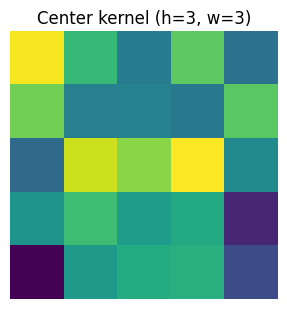

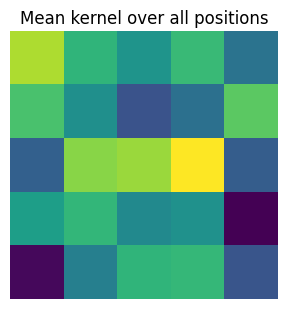

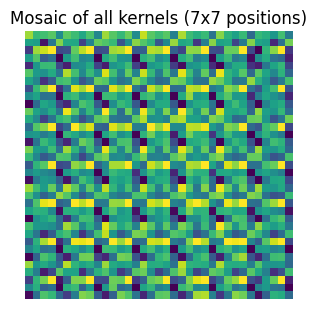

In [9]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def extract_dynamic_kernels(model, x_img=None):
    """
    Returns dynamic kernels right before GAP.
    Supports:
      - MobileNetV3_INV (inv_head.inv): [B, hidden, k, k, H, W]
      - (still works with pv_head / pi_head if present in other models)
    """
    model.eval()
    dev = next(model.parameters()).device

    # If you don't pass a real image, use a random 224x224 (content-dependent kernels will still vary)
    if x_img is None:
        x_img = torch.randn(1, 3, 224, 224, device=dev)
    if x_img.dim() == 5:  # [B,T,3,H,W] -> take t=0
        x_img = x_img[:, 0]

    # Backbone feature map
    feat = model.features(x_img)  # [B, feat_dim, H, W]

    # ---- MobileNetV3_INV path (your current model) ----
    if hasattr(model, "inv_head") and hasattr(model.inv_head, "inv"):
        hidden = model.inv_head.act(model.inv_head.bn1(model.inv_head.reduce(feat)))
        K = model.inv_head.inv.get_kernels(hidden)     # [B, hidden, k, k, H, W]
        return K

    # ---- Fallbacks (if you reuse this file with other heads) ----
    if hasattr(model, "pv_head") and hasattr(model.pv_head, "pv"):
        hidden = model.pv_head.act(model.pv_head.bn1(model.pv_head.reduce(feat)))
        return model.pv_head.pv.get_kernels(hidden)    # [B, hidden, k, k, H, W]

    if hasattr(model, "pi_head") and hasattr(model.pi_head, "pi"):
        # positional-only (content-independent)
        H, W = feat.shape[-2:]
        return model.pi_head.pi.get_kernels(H, W, B=feat.size(0), device=dev)  # [B,1,k,k,H,W]

    raise RuntimeError("No compatible kernel generator found on the model (inv_head / pv_head / pi_head).")


# 1) Grab kernels (use a REAL image batch if possible)
K = extract_dynamic_kernels(model, x_img=None)   # if None, uses random 224x224

# 2) Collapse the channel/head axis if needed
if K.shape[1] == 1:
    # PositionalInvolution: [B,1,k,k,H,W] -> [k,k,H,W]
    K_all = K[0, 0]
else:
    # Involution/PV: [B,hidden,k,k,H,W] -> average hidden to visualize
    K_all = K[0].mean(dim=0)                    # or pick a channel: K[0, ch]

k = K_all.shape[0]
H, W = K_all.shape[-2:]

# (A) Center kernel
hc, wc = H // 2, W // 2
K_center = K_all[:, :, hc, wc].cpu().numpy()
show_heatmap(K_center, title=f"Center kernel (h={hc}, w={wc})")

# (B) Mean kernel over all positions
K_mean = K_all.mean(dim=(2, 3)).cpu().numpy()
show_heatmap(K_mean, title="Mean kernel over all positions")

# (C) Mosaic of all position-specific kernels
mosaic = kernels_to_mosaic(K_all.cpu(), normalize=True).numpy()
show_heatmap(mosaic, title=f"Mosaic of all kernels ({H}x{W} positions)")


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import torch.nn.functional as F

# ---------------- Supervised Contrastive Loss ----------------
class SupConLoss(nn.Module):
    """
    Stable Supervised Contrastive Loss (handles no-positive anchors, avoids -inf).
    features: [B, D] or [B, V, D]; labels: [B]
    """
    def __init__(self, temperature: float = 0.07):
        super().__init__()
        self.t = temperature

    def forward(self, features, labels):
        if features.dim() == 2:  # [B, D] -> [B, 1, D]
            features = features.unsqueeze(1)
        # L2 normalize
        features = F.normalize(features, dim=-1)

        B, V, D = features.shape
        feats = features.reshape(B * V, D)                     # [BV, D]

        # Cosine sim logits
        logits = torch.matmul(feats, feats.t()) / self.t       # [BV, BV]

        # Mask self-contrast with a large negative (not -inf) for log_softmax stability
        self_mask = torch.eye(B * V, dtype=torch.bool, device=feats.device)
        logits = logits.masked_fill(self_mask, -1e9)

        # Log-softmax over keys
        log_prob = F.log_softmax(logits, dim=1)                # [BV, BV]

        # Supervised positives: same label
        labels = labels.view(B, 1)
        pos_mask = (labels == labels.t()).float().to(feats.device)  # [B, B]
        pos_mask = pos_mask.repeat_interleave(V, 0).repeat_interleave(V, 1)
        pos_mask = pos_mask.masked_fill(self_mask, 0.0)

        # Count positives per anchor
        pos_count = pos_mask.sum(dim=1)                        # [BV]
        valid = pos_count > 0                                  # anchors with >=1 positive
        if not valid.any():
            # no positives in the whole batch -> return 0 to avoid NaN and let CE drive
            return logits.new_zeros(())

        # Average log-prob over positives only
        mean_log_prob_pos = (log_prob * pos_mask).sum(dim=1) / pos_count.clamp(min=1)
        loss = -mean_log_prob_pos[valid].mean()
        return loss

# ---------------- Projection Head (for SupCon) ----------------
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, hidden=256, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out_dim, bias=True),
        )
    def forward(self, x):  # x: [B, in_dim]
        return self.net(x)

# --------- Setup: criterion, projection, optimizer, ckpt dir ----------
supcon_criterion = SupConLoss(temperature=0.07)

# Projection head maps your 960-D pooled feature -> 128-D contrastive embedding
# proj_head = ProjectionHead(in_dim=model.cnn.out_dim, hidden=256, out_dim=128).to(device)
proj_head = ProjectionHead(in_dim=model.fc.in_features, hidden=256, out_dim=128).to(device)


# Optional CE to train classifier jointly (set CE_WEIGHT=0.0 for pure SupCon pretrain)
CE_WEIGHT = 1.0
ce_criterion = nn.CrossEntropyLoss() if CE_WEIGHT > 0 else None

# Optimizer: encoder + projection head (+ classifier if using CE)
optim_params = list(model.parameters()) + list(proj_head.parameters())
optimizer = optim.Adam(optim_params, lr=1e-4, weight_decay=1e-4)

checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(state, is_best, filename="checkpoint.pth"):
    torch.save(state, os.path.join(checkpoint_dir, filename))
    if is_best:
        torch.save(state, os.path.join(checkpoint_dir, "best_model.pth"))

# ---------------- Training / Validation (SupCon) ----------------
def _ensure_video_shape(x):
    # Model expects [B, T, C, H, W]. If we got [B, C, H, W], add T=1.
    if x.dim() == 4:
        x = x.unsqueeze(1)
    return x

def get_feats(model, x):
    """
    Returns the embedding BEFORE the classifier FC.
    Supports:
      - CNNTemporalAvgPooling (uses extract_intermediate_features)
      - MobileNetV2_PI / MobileNetV3... (uses forward_features if present,
        or reconstructs features as features -> pi_head? -> avgpool -> flatten)
    """
    # If input is [B,T,C,H,W] and the model is image-only, keep T=1 first frame
    if x.dim() == 5 and not hasattr(model, 'extract_intermediate_features'):
        x = x[:, 0]  # [B,C,H,W]

    if hasattr(model, 'extract_intermediate_features'):
        # Your video wrapper returns (cnn_features, temporal_avg_features)
        _, feats = model.extract_intermediate_features(x)
        return feats

    if hasattr(model, 'forward_features'):
        return model.forward_features(x)  # many backbones expose this

    # Fallback: reconstruct pre-FC features
    h = model.features(x)                     # backbone features
    if hasattr(model, 'pi_head'):
        h = model.pi_head(h)                  # optional positional involution head
    h = model.avgpool(h)
    return torch.flatten(h, 1)                # [B, D]

def train_epoch(model, loader, optimizer, epoch):
    model.train()
    proj_head.train()
    running_loss, correct, total = 0.0, 0, 0

    with tqdm(loader, unit="batch") as tepoch:
        for inputs, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = _ensure_video_shape(inputs)

            optimizer.zero_grad()

            # Get pooled frame features (e.g., 960-D) without using classifier
            # Your class exposes this helper; if not, swap with your own:
            #   feats = model.forward_features(inputs)
            _, feats = model.extract_intermediate_features(inputs)   # [B, D]

            # Contrastive projections
            z = proj_head(feats)                                     # [B, 128]

            # Supervised Contrastive loss
            loss = 0*supcon_criterion(z, labels)

            # (Optional) joint CE to make classifier learn during SupCon phase
            if CE_WEIGHT > 0:
                logits = model.fc(feats)                             # [B, num_classes]
                ce_loss = ce_criterion(logits, labels)
                loss = loss + CE_WEIGHT * ce_loss
                # Track accuracy from logits
                _, pred = torch.max(logits, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()

            # Backprop
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            if CE_WEIGHT > 0:
                tepoch.set_postfix(loss=running_loss / max(total, 1),
                                   acc=100.0 * correct / max(total, 1))
            else:
                tepoch.set_postfix(loss=running_loss / ((tepoch.n + 1) * inputs.size(0)))

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = (100.0 * correct / max(total, 1)) if CE_WEIGHT > 0 else 0.0
    return epoch_loss, epoch_acc

@torch.no_grad()
def validate_epoch(model, loader):
    model.eval()
    proj_head.eval()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = _ensure_video_shape(inputs)

        # _, feats = model.extract_intermediate_features(inputs)   # [B, D]
        feats = get_feats(model, inputs)
        z = proj_head(feats)
        loss = 0*supcon_criterion(z, labels)

        if CE_WEIGHT > 0:
            logits = model.fc(feats)
            # For validation loss, keep it purely SupCon (consistent with training primary objective)
            # But compute accuracy from logits for monitoring:
            ce_loss = ce_criterion(logits, labels)
            loss = loss + CE_WEIGHT * ce_loss
            _, pred = torch.max(logits, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = (100.0 * correct / max(total, 1)) if CE_WEIGHT > 0 else 0.0
    return epoch_loss, epoch_acc

# ---------------- Train loop (unchanged caller) ----------------
best_val_loss = float('inf')
early_stopping_counter = 0
early_stopping_patience = 5
num_epochs = 100

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, epoch)
    val_loss, val_acc = validate_epoch(model, val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save current checkpoint (include proj_head)
    save_checkpoint({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'proj_head_state_dict': proj_head.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'ce_weight': CE_WEIGHT,
    }, is_best=False, filename=f"checkpoint_epoch_{epoch + 1}.pth")

    # Best model by lowest SupCon validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'proj_head_state_dict': proj_head.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'ce_weight': CE_WEIGHT,
        }, is_best=True, filename=f"best_ce_supervised.pth")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break


Epoch 0: 100%|██████████| 44/44 [01:08<00:00,  1.55s/batch, acc=86.5, loss=0.35] 


Epoch 1/100 | Train Loss: 0.3496 | Val Loss: 0.2371 | Val Acc: 95.14%


Epoch 1: 100%|██████████| 44/44 [00:59<00:00,  1.34s/batch, acc=99.4, loss=0.0505]


Epoch 2/100 | Train Loss: 0.0505 | Val Loss: 0.0855 | Val Acc: 98.00%


Epoch 2: 100%|██████████| 44/44 [00:58<00:00,  1.34s/batch, acc=99.5, loss=0.0255]


Epoch 3/100 | Train Loss: 0.0255 | Val Loss: 0.0749 | Val Acc: 97.43%


Epoch 3: 100%|██████████| 44/44 [00:57<00:00,  1.31s/batch, acc=99.8, loss=0.0145]


Epoch 4/100 | Train Loss: 0.0145 | Val Loss: 0.0572 | Val Acc: 98.00%


Epoch 4: 100%|██████████| 44/44 [00:58<00:00,  1.34s/batch, acc=100, loss=0.00414]


Epoch 5/100 | Train Loss: 0.0041 | Val Loss: 0.0586 | Val Acc: 97.71%


Epoch 5: 100%|██████████| 44/44 [00:58<00:00,  1.34s/batch, acc=99.8, loss=0.00724]


Epoch 6/100 | Train Loss: 0.0072 | Val Loss: 0.0375 | Val Acc: 98.86%


Epoch 6: 100%|██████████| 44/44 [00:58<00:00,  1.34s/batch, acc=99.7, loss=0.011]  


Epoch 7/100 | Train Loss: 0.0110 | Val Loss: 0.0372 | Val Acc: 98.57%


Epoch 7: 100%|██████████| 44/44 [00:58<00:00,  1.33s/batch, acc=99.9, loss=0.00521]


Epoch 8/100 | Train Loss: 0.0052 | Val Loss: 0.0189 | Val Acc: 99.43%


Epoch 8: 100%|██████████| 44/44 [00:59<00:00,  1.34s/batch, acc=99.7, loss=0.0073] 


Epoch 9/100 | Train Loss: 0.0073 | Val Loss: 0.0750 | Val Acc: 96.86%


Epoch 9: 100%|██████████| 44/44 [00:58<00:00,  1.34s/batch, acc=100, loss=0.00258]


Epoch 10/100 | Train Loss: 0.0026 | Val Loss: 0.1353 | Val Acc: 95.71%


Epoch 10: 100%|██████████| 44/44 [00:58<00:00,  1.34s/batch, acc=99.9, loss=0.00507]


Epoch 11/100 | Train Loss: 0.0051 | Val Loss: 0.0514 | Val Acc: 98.29%


Epoch 11: 100%|██████████| 44/44 [00:58<00:00,  1.33s/batch, acc=100, loss=0.00108]


Epoch 12/100 | Train Loss: 0.0011 | Val Loss: 0.0343 | Val Acc: 98.29%


Epoch 12: 100%|██████████| 44/44 [00:58<00:00,  1.34s/batch, acc=99.9, loss=0.00613]


Epoch 13/100 | Train Loss: 0.0061 | Val Loss: 0.0086 | Val Acc: 100.00%


Epoch 13: 100%|██████████| 44/44 [00:58<00:00,  1.33s/batch, acc=99.8, loss=0.0053] 


Epoch 14/100 | Train Loss: 0.0053 | Val Loss: 0.0111 | Val Acc: 99.71%


Epoch 14: 100%|██████████| 44/44 [00:59<00:00,  1.34s/batch, acc=99.6, loss=0.0103] 


Epoch 15/100 | Train Loss: 0.0103 | Val Loss: 0.0274 | Val Acc: 99.14%


Epoch 15: 100%|██████████| 44/44 [00:58<00:00,  1.33s/batch, acc=99.6, loss=0.00883]


Epoch 16/100 | Train Loss: 0.0088 | Val Loss: 0.0512 | Val Acc: 98.00%


Epoch 16: 100%|██████████| 44/44 [00:58<00:00,  1.33s/batch, acc=100, loss=0.00221]


Epoch 17/100 | Train Loss: 0.0022 | Val Loss: 0.0099 | Val Acc: 99.71%


Epoch 17: 100%|██████████| 44/44 [00:58<00:00,  1.33s/batch, acc=100, loss=0.000998]


Epoch 18/100 | Train Loss: 0.0010 | Val Loss: 0.0072 | Val Acc: 99.71%


Epoch 18: 100%|██████████| 44/44 [00:59<00:00,  1.34s/batch, acc=99.9, loss=0.0036] 


Epoch 19/100 | Train Loss: 0.0036 | Val Loss: 0.0074 | Val Acc: 100.00%


Epoch 19: 100%|██████████| 44/44 [00:58<00:00,  1.33s/batch, acc=99.9, loss=0.00881]


Epoch 20/100 | Train Loss: 0.0088 | Val Loss: 0.0056 | Val Acc: 100.00%


Epoch 20: 100%|██████████| 44/44 [00:59<00:00,  1.34s/batch, acc=99.9, loss=0.00348]


Epoch 21/100 | Train Loss: 0.0035 | Val Loss: 0.0149 | Val Acc: 99.71%


Epoch 21: 100%|██████████| 44/44 [00:58<00:00,  1.34s/batch, acc=100, loss=0.000928]


Epoch 22/100 | Train Loss: 0.0009 | Val Loss: 0.0126 | Val Acc: 99.71%


Epoch 22: 100%|██████████| 44/44 [00:58<00:00,  1.33s/batch, acc=100, loss=0.000685]


Epoch 23/100 | Train Loss: 0.0007 | Val Loss: 0.0063 | Val Acc: 99.71%


Epoch 23: 100%|██████████| 44/44 [00:58<00:00,  1.33s/batch, acc=100, loss=0.000675]


Epoch 24/100 | Train Loss: 0.0007 | Val Loss: 0.0060 | Val Acc: 99.71%


Epoch 24: 100%|██████████| 44/44 [00:58<00:00,  1.33s/batch, acc=100, loss=0.00118]


Epoch 25/100 | Train Loss: 0.0012 | Val Loss: 0.0053 | Val Acc: 99.71%


Epoch 25: 100%|██████████| 44/44 [00:58<00:00,  1.33s/batch, acc=99.9, loss=0.00144]


Epoch 26/100 | Train Loss: 0.0014 | Val Loss: 0.0085 | Val Acc: 99.71%


Epoch 26: 100%|██████████| 44/44 [00:58<00:00,  1.33s/batch, acc=99.9, loss=0.00517]


Epoch 27/100 | Train Loss: 0.0052 | Val Loss: 0.0021 | Val Acc: 100.00%


Epoch 27: 100%|██████████| 44/44 [00:58<00:00,  1.33s/batch, acc=99.9, loss=0.00415]


Epoch 28/100 | Train Loss: 0.0041 | Val Loss: 0.0240 | Val Acc: 99.14%


Epoch 28: 100%|██████████| 44/44 [00:58<00:00,  1.32s/batch, acc=100, loss=0.00191]


Epoch 29/100 | Train Loss: 0.0019 | Val Loss: 0.0090 | Val Acc: 100.00%


Epoch 29: 100%|██████████| 44/44 [00:58<00:00,  1.32s/batch, acc=99.9, loss=0.0028] 


Epoch 30/100 | Train Loss: 0.0028 | Val Loss: 0.0048 | Val Acc: 100.00%


Epoch 30: 100%|██████████| 44/44 [00:58<00:00,  1.32s/batch, acc=100, loss=0.000832]


Epoch 31/100 | Train Loss: 0.0008 | Val Loss: 0.0041 | Val Acc: 100.00%


Epoch 31: 100%|██████████| 44/44 [00:59<00:00,  1.35s/batch, acc=99.9, loss=0.00155]


Epoch 32/100 | Train Loss: 0.0015 | Val Loss: 0.0025 | Val Acc: 100.00%
Early stopping triggered


In [11]:
# # ---- freeze encoder, train only the classification head ----
# def freeze_encoder(model):
#     model.eval()  # fix BatchNorm running stats during linear probe
#     if hasattr(model, 'features'):
#         for p in model.features.parameters(): p.requires_grad = False
#     if hasattr(model, 'pi_head'):
#         for p in model.pi_head.parameters(): p.requires_grad = False
#     if hasattr(model, 'avgpool'):
#         for p in model.avgpool.parameters(): p.requires_grad = False

# def unfreeze_encoder(model):
#     model.train()
#     if hasattr(model, 'features'):
#         for p in model.features.parameters(): p.requires_grad = True
#     if hasattr(model, 'pi_head'):
#         for p in model.pi_head.parameters(): p.requires_grad = True
#     if hasattr(model, 'avgpool'):
#         for p in model.avgpool.parameters(): p.requires_grad = True

# @torch.no_grad()
# def _ensure_video_shape_ce(x):
#     # Forward accepts both 4D and 5D, but we keep interface consistent.
#     # For pure image batches nothing to do.
#     return x

# def train_epoch_ce(model, loader, optimizer, epoch, criterion):
#     model.train()  # we'll keep dropout active in the head
#     running_loss, correct, total = 0.0, 0, 0

#     with tqdm(loader, unit="batch") as tepoch:
#         for inputs, labels in tepoch:
#             tepoch.set_description(f"[LP] Epoch {epoch}")
#             inputs, labels = inputs.to(device), labels.to(device)
#             inputs = _ensure_video_shape_ce(inputs)

#             optimizer.zero_grad(set_to_none=True)
#             logits = model(inputs)                    # uses frozen encoder + fc
#             loss = criterion(logits, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * labels.size(0)
#             _, pred = torch.max(logits, 1)
#             total += labels.size(0)
#             correct += (pred == labels).sum().item()
#             tepoch.set_postfix(loss=running_loss/total, acc=100*correct/total)

#     return running_loss/len(loader.dataset), 100*correct/max(total,1)

# @torch.no_grad()
# def validate_epoch_ce(model, loader, criterion):
#     model.eval()
#     running_loss, correct, total = 0.0, 0, 0
#     for inputs, labels in loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         logits = model(inputs)
#         loss = criterion(logits, labels)
#         running_loss += loss.item() * labels.size(0)
#         _, pred = torch.max(logits, 1)
#         total += labels.size(0)
#         correct += (pred == labels).sum().item()
#     return running_loss/len(loader.dataset), 100*correct/max(total,1)

# # ---- Run linear probe ----
# freeze_encoder(model)
# # (Optional) re-init fc if you want a clean start for classification
# # nn.init.normal_(model.fc.weight, 0, 0.01); nn.init.zeros_(model.fc.bias)

# clf_optimizer = optim.Adam(model.fc.parameters(), lr=3e-4, weight_decay=1e-4)
# ce_criterion = nn.CrossEntropyLoss()

# best_val_acc = 0.0
# for epoch in range(10):  # 5–15 epochs usually enough
#     tr_loss, tr_acc = train_epoch_ce(model, train_loader, clf_optimizer, epoch, ce_criterion)
#     va_loss, va_acc = validate_epoch_ce(model, val_loader, ce_criterion)
#     print(f"[LP] Epoch {epoch+1} | Train {tr_loss:.4f}/{tr_acc:.2f}% | Val {va_loss:.4f}/{va_acc:.2f}%")
#     if va_acc > best_val_acc:
#         best_val_acc = va_acc
#         save_checkpoint({'epoch': epoch+1,
#                          'model_state_dict': model.state_dict(),
#                          'optimizer_state_dict': clf_optimizer.state_dict(),
#                          'val_acc': va_acc}, is_best=True, filename="best_linear_probe.pth")


In [12]:
# # Unfreeze encoder and fine-tune everything with smaller LR on encoder
# # unfreeze_encoder(model)

# finetune_optimizer = optim.Adam([
#     {'params': model.features.parameters(), 'lr': 1e-5, 'weight_decay': 1e-5},
#     {'params': model.pi_head.parameters(), 'lr': 1e-5, 'weight_decay': 1e-5},
#     {'params': model.fc.parameters(),       'lr': 3e-4, 'weight_decay': 1e-4},
# ], lr=1e-4)

# # (optional) cosine or step scheduler helps
# # scheduler = optim.lr_scheduler.CosineAnnealingLR(finetune_optimizer, T_max=20)

# best_val_acc = 0.0
# for epoch in range(5):  # 10–30 epochs typical
#     tr_loss, tr_acc = train_epoch_ce(model, train_loader, finetune_optimizer, epoch, ce_criterion)
#     va_loss, va_acc = validate_epoch_ce(model, val_loader, ce_criterion)
#     # scheduler.step()
#     print(f"[FT] Epoch {epoch+1} | Train {tr_loss:.4f}/{tr_acc:.2f}% | Val {va_loss:.4f}/{va_acc:.2f}%")
#     if va_acc > best_val_acc:
#         best_val_acc = va_acc
#         save_checkpoint({'epoch': epoch+1,
#                          'model_state_dict': model.state_dict(),
#                          'optimizer_state_dict': finetune_optimizer.state_dict(),
#                          'val_acc': va_acc}, is_best=True, filename="best_finetune.pth")


# INFERENCE

Step 4: Visualize a Random Sample and its Class Label

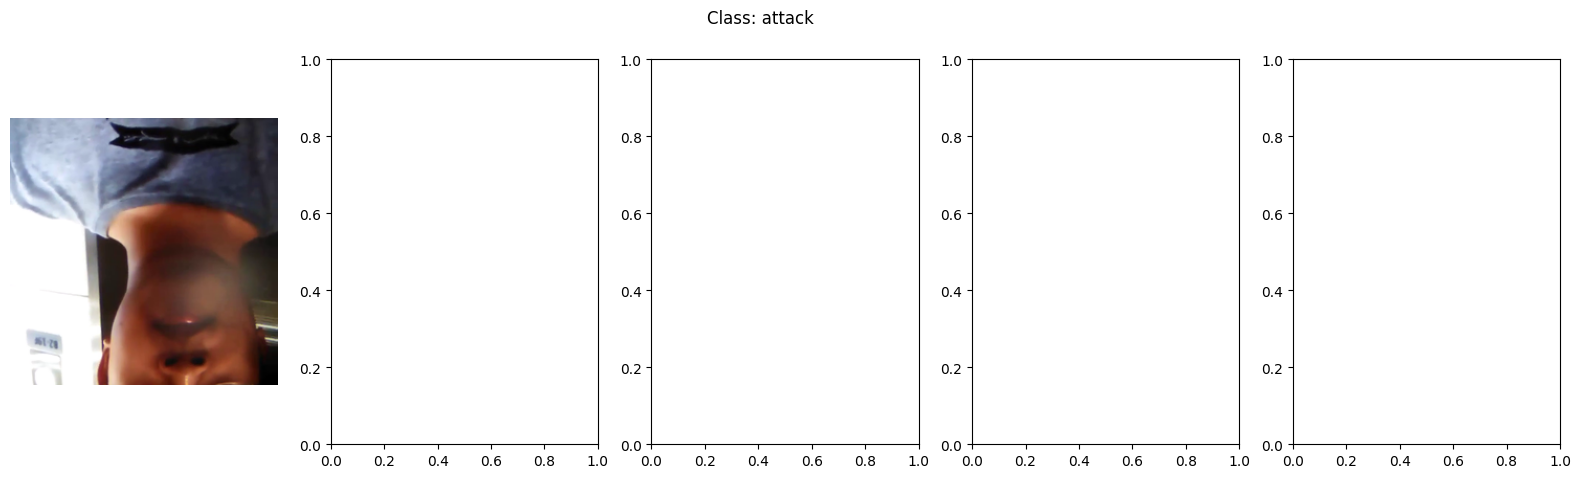

In [13]:
import matplotlib.pyplot as plt

def visualize_sample(dataset):
    idx = np.random.randint(len(dataset))
    frames, label = dataset[idx]
    frames = frames[0:5,:,:]
    class_name = dataset.classes[label]
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    for i, frame in enumerate(frames):
        axes[i].imshow(frame.permute(1, 2, 0))
        axes[i].axis('off')
    plt.suptitle(f"Class: {class_name}")
    plt.show()

# Visualize a random sample
visualize_sample(train_dataset)


Step 5: Evaluate on Test Dataset

In [14]:
import time
import torch
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc

def evaluate_all(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []
    all_times = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            inputs = inputs.squeeze() # FOR NON SPATIO
            
            # Start timing for prediction
            start_time = time.time()
            outputs = model(inputs)
            inference_time = time.time() - start_time
            all_times.append(inference_time)
            
            # Loss calculation
            # loss = criterion(outputs, labels)
            # running_loss += loss.item() * inputs.size(0)
            
            # For AUC, EER, etc.
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Assuming class 1 is the target class
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate metrics like AUC-ROC, EER, etc. based on collected labels and probabilities
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    auc_roc = auc(fpr, tpr)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

    # Calculate FAR, FRR, HTER, and Youden's Index
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    youdens_index = tpr[optimal_idx] - fpr[optimal_idx]
    far = fpr[optimal_idx]
    frr = fnr[optimal_idx]
    hter = (far + frr) / 2

    # Average inference time
    avg_inference_time = np.mean(all_times)

    # Test loss and accuracy
    # test_loss = running_loss / len(loader.dataset)
    test_acc = 100. * correct / total

    # Return dictionary with all results
    return {
        # 'test_loss': test_loss,
        'test_acc': test_acc,
        'auc_roc': auc_roc,
        'eer': eer,
        'hter': hter,
        'far': far,
        'frr': frr,
        'youdens_index': youdens_index,
        'optimal_threshold': optimal_threshold,
        'avg_inference_time': avg_inference_time,
        'fpr': fpr,
        'tpr': tpr,
        'labels': all_labels,
        'probs': all_probs
    }


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

def generate_evaluation_summary(results):
    # Extract metrics from the results dictionary
    # test_loss = results['test_loss']
    test_acc = results['test_acc']
    auc_roc = results['auc_roc']
    eer = results['eer']
    hter = results['hter']
    far = results['far']
    frr = results['frr']
    youdens_index = results['youdens_index']
    optimal_threshold = results['optimal_threshold']
    avg_inference_time = results['avg_inference_time']

    # Print summary
    print("\n--- Evaluation Summary ---")
    # print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"Equal Error Rate (EER): {eer:.4f}")
    print(f"Half Total Error Rate (HTER): {hter:.4f}")
    print(f"False Acceptance Rate (FAR): {far:.4f}")
    print(f"False Rejection Rate (FRR): {frr:.4f}")
    print(f"Youden's Index (Max): {youdens_index:.4f}")
    print(f"Optimal Threshold (Youden's Index): {optimal_threshold:.4f}")
    print(f"Average inference time per sample: {avg_inference_time:.6f} seconds")

    # Plot AUC-ROC Curve
    plot_roc_curve(results)

def plot_roc_curve(results):
    """Generate ROC curve from the evaluation results."""
    fpr = results['fpr']
    tpr = results['tpr']
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {results["auc_roc"]:.4f}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_error_histogram(far, frr, eer):
    """Plot histograms of FAR, FRR, and EER values."""
    plt.figure(figsize=(10, 6))

    # Plot FAR
    plt.subplot(1, 3, 1)
    plt.bar(['FAR'], [far], color='red')
    plt.ylabel('Rate')
    plt.title('False Acceptance Rate (FAR)')

    # Plot FRR
    plt.subplot(1, 3, 2)
    plt.bar(['FRR'], [frr], color='blue')
    plt.ylabel('Rate')
    plt.title('False Rejection Rate (FRR)')

    # Plot EER
    plt.subplot(1, 3, 3)
    plt.bar(['EER'], [eer], color='green')
    plt.ylabel('Rate')
    plt.title('Equal Error Rate (EER)')

    plt.tight_layout()
    plt.show()

def plot_inference_time(avg_inference_time):
    """Plot inference time as a bar chart."""
    plt.figure(figsize=(6, 4))
    plt.bar(['Average Inference Time'], [avg_inference_time], color='purple')
    plt.ylabel('Time (seconds)')
    plt.title('Average Inference Time per Sample')
    plt.show()



In [16]:
test_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu//test', transform=transform, num_frames=1)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn, pin_memory=True)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


checkpoint = torch.load('checkpoints/best_ce_supervised.pth', weights_only=True)
# checkpoint = torch.load('checkpoints/best_finetune.pth', weights_only=True)
# checkpoint = torch.load('checkpoints/best_linear_probe.pth', weights_only=True)

# checkpoint = torch.load('checkpoints/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# model_scripted = torch.jit.script(model) # Export to TorchScript
# model_scripted.save('checkpoints/best_complete_model_scripted.pt') # Save

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']



<All keys matched successfully>


--- Evaluation Summary ---
Test Accuracy: 99.26%
AUC-ROC: 0.9998
Equal Error Rate (EER): 0.0077
Half Total Error Rate (HTER): 0.0061
False Acceptance Rate (FAR): 0.0077
False Rejection Rate (FRR): 0.0045
Youden's Index (Max): 0.9878
Optimal Threshold (Youden's Index): 0.0820
Average inference time per sample: 0.047136 seconds


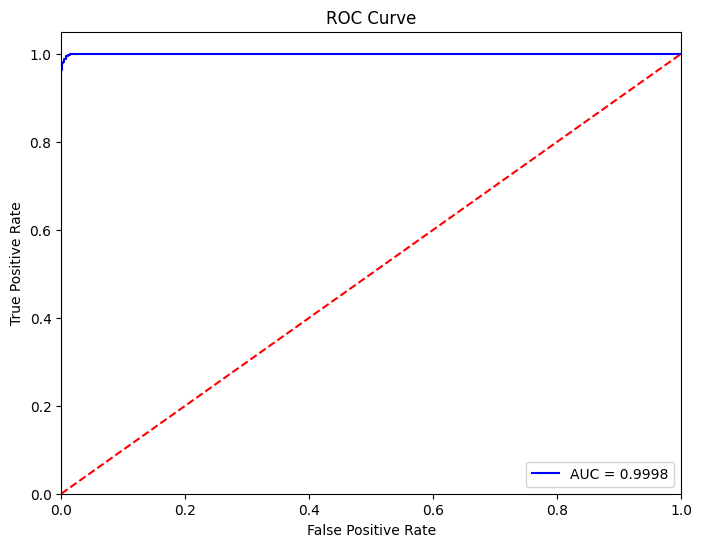

In [17]:

# Assuming `evaluate` returns the results dictionary
results = evaluate_all(model, test_loader)

# Generate the summary and plot graphs
generate_evaluation_summary(results)

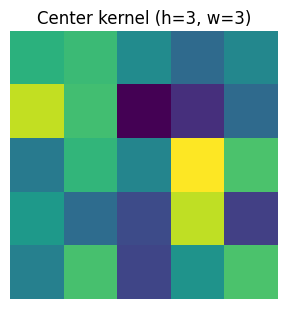

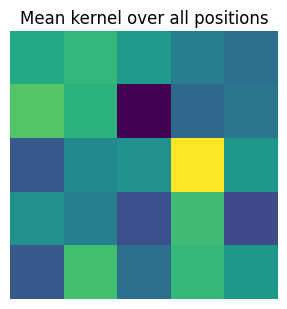

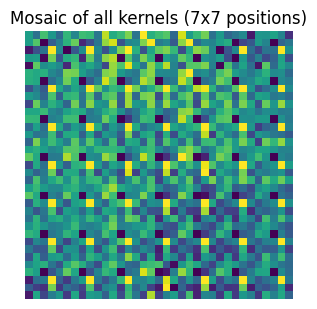

In [18]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def extract_dynamic_kernels(model, x_img=None):
    """
    Returns dynamic kernels right before GAP.
    Supports:
      - MobileNetV3_INV (inv_head.inv): [B, hidden, k, k, H, W]
      - (still works with pv_head / pi_head if present in other models)
    """
    model.eval()
    dev = next(model.parameters()).device

    # If you don't pass a real image, use a random 224x224 (content-dependent kernels will still vary)
    if x_img is None:
        x_img = torch.randn(1, 3, 224, 224, device=dev)
    if x_img.dim() == 5:  # [B,T,3,H,W] -> take t=0
        x_img = x_img[:, 0]

    # Backbone feature map
    feat = model.features(x_img)  # [B, feat_dim, H, W]

    # ---- MobileNetV3_INV path (your current model) ----
    if hasattr(model, "inv_head") and hasattr(model.inv_head, "inv"):
        hidden = model.inv_head.act(model.inv_head.bn1(model.inv_head.reduce(feat)))
        K = model.inv_head.inv.get_kernels(hidden)     # [B, hidden, k, k, H, W]
        return K

    # ---- Fallbacks (if you reuse this file with other heads) ----
    if hasattr(model, "pv_head") and hasattr(model.pv_head, "pv"):
        hidden = model.pv_head.act(model.pv_head.bn1(model.pv_head.reduce(feat)))
        return model.pv_head.pv.get_kernels(hidden)    # [B, hidden, k, k, H, W]

    if hasattr(model, "pi_head") and hasattr(model.pi_head, "pi"):
        # positional-only (content-independent)
        H, W = feat.shape[-2:]
        return model.pi_head.pi.get_kernels(H, W, B=feat.size(0), device=dev)  # [B,1,k,k,H,W]

    raise RuntimeError("No compatible kernel generator found on the model (inv_head / pv_head / pi_head).")


# 1) Grab kernels (use a REAL image batch if possible)
K = extract_dynamic_kernels(model, x_img=None)   # if None, uses random 224x224

# 2) Collapse the channel/head axis if needed
if K.shape[1] == 1:
    # PositionalInvolution: [B,1,k,k,H,W] -> [k,k,H,W]
    K_all = K[0, 0]
else:
    # Involution/PV: [B,hidden,k,k,H,W] -> average hidden to visualize
    K_all = K[0].mean(dim=0)                    # or pick a channel: K[0, ch]

k = K_all.shape[0]
H, W = K_all.shape[-2:]

# (A) Center kernel
hc, wc = H // 2, W // 2
K_center = K_all[:, :, hc, wc].cpu().numpy()
show_heatmap(K_center, title=f"Center kernel (h={hc}, w={wc})")

# (B) Mean kernel over all positions
K_mean = K_all.mean(dim=(2, 3)).cpu().numpy()
show_heatmap(K_mean, title="Mean kernel over all positions")

# (C) Mosaic of all position-specific kernels
mosaic = kernels_to_mosaic(K_all.cpu(), normalize=True).numpy()
show_heatmap(mosaic, title=f"Mosaic of all kernels ({H}x{W} positions)")


In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

def extract_intermediate_features(self, x):
        """Extract features before and after LSTM."""
        batch_size, seq_len, C, H, W = x.size()
        cnn_features = []
        for t in range(seq_len):
            with torch.no_grad():
                feature = self.cnn(x[:, t, :, :, :])  # CNN output (before LSTM)
            cnn_features.append(feature)
        cnn_features = torch.stack(cnn_features, dim=1)  # Shape: [batch_size, seq_len, cnn_output_dim]
        lstm_out, _ = self.lstm(cnn_features)  # LSTM output
        lstm_out_last = lstm_out[:, -1, :]  # Take the output of the last LSTM cell
        return cnn_features, lstm_out_last

def extract_features(model, loader):
    """Extract features before and after the LSTM layer."""
    model.eval()
    features_before_lstm = []
    features_after_lstm = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            
            # Extract features using the model
            before_lstm, after_lstm = model.extract_intermediate_features(inputs)
            
            # Move features to CPU for t-SNE processing
            features_before_lstm.append(before_lstm.cpu().view(before_lstm.size(0), -1))  # Flatten the CNN features
            features_after_lstm.append(after_lstm.cpu())
            labels_list.append(labels.cpu())

    # Stack features and labels
    features_before_lstm = torch.cat(features_before_lstm, dim=0)
    features_after_lstm = torch.cat(features_after_lstm, dim=0)
    labels_list = torch.cat(labels_list, dim=0)
    
    return features_before_lstm, features_after_lstm, labels_list


In [20]:
from sklearn.manifold import TSNE

def apply_tsne(features):
    """Apply t-SNE to reduce features to 2D."""
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)
    return reduced_features


In [21]:
import matplotlib.pyplot as plt

def plot_tsne(reduced_features, labels, title):
    """Plot t-SNE results."""
    plt.figure(figsize=(8, 6))
    
    for label in torch.unique(labels):
        idx = labels == label
        plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], label=f'Class {label.item()}', alpha=0.7)
    
    plt.title(title)
    plt.xlabel('t-SNE Dim 1')
    plt.ylabel('t-SNE Dim 2')
    plt.legend()
    plt.show()


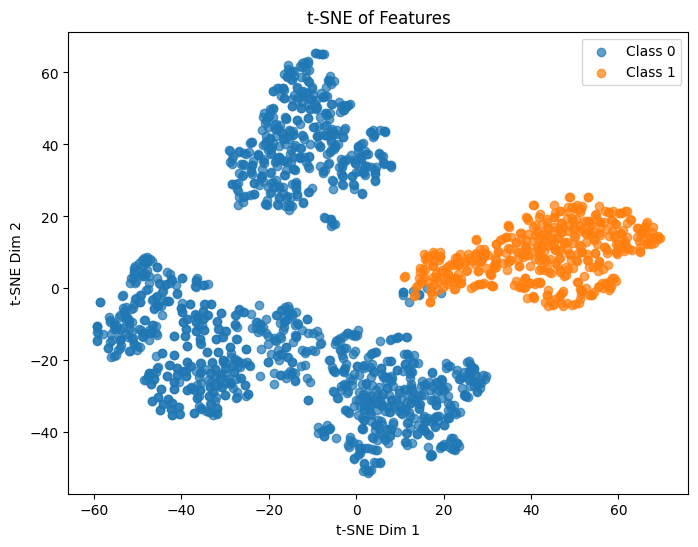

In [22]:
def visualize_tsne_before_after_lstm(model, loader):
    # Extract features before and after LSTM
    features_before_lstm, features_after_lstm, labels_list = extract_features(model, loader)
    
    # Apply t-SNE
    tsne_before_lstm = apply_tsne(features_before_lstm)
    # tsne_after_lstm = apply_tsne(features_after_lstm)
    
    # Plot the t-SNE results
    plot_tsne(tsne_before_lstm, labels_list, title="t-SNE of Features")
    # plot_tsne(tsne_after_lstm, labels_list, title="t-SNE of Features After LSTM")

# Usage example:
# Load the model weights
# checkpoint = torch.load('best_model.pth', weights_only=True)
# model.load_state_dict(checkpoint['model_state_dict'])

# Load the model weights, ignoring missing/unexpected keys
checkpoint = torch.load('checkpoints/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)

test_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu//test', transform=transform, num_frames=1)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, pin_memory=True)

# Visualize t-SNE before and after LSTM
visualize_tsne_before_after_lstm(model, test_loader)

# test_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu//test', transform=transform, num_frames=10)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, pin_memory=True)


# Visualize t-SNE before and after LSTM
# visualize_tsne_before_after_lstm(model, test_loader)



[Grad-CAM] Using target layer: inv_head


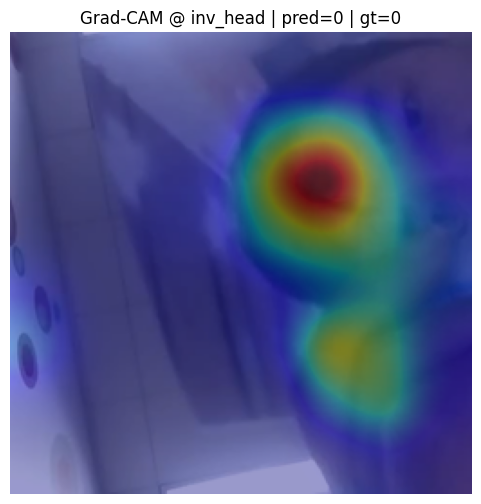

In [23]:
import torch
from torch.utils.data import DataLoader
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

device = next(model.parameters()).device

def find_cam_layer(model, sample):
    """Return (name, module) of the last layer producing a 4D feature map (B,C,H,W) with H,W>1."""
    feats = {}
    hooks = []

    def make_hook(name):
        def hook(_m, _in, out):
            if isinstance(out, (tuple, list)):
                out = out[0]
            if torch.is_tensor(out) and out.dim() == 4:
                B, C, H, W = out.shape
                if H > 1 and W > 1:
                    feats[name] = (B, C, H, W)
        return hook

    for name, m in model.named_modules():
        hooks.append(m.register_forward_hook(make_hook(name)))

    model.eval()
    # --- IMPORTANT: enable grad here (do NOT use torch.no_grad()) ---
    with torch.enable_grad():
        sample = sample.clone().detach().requires_grad_(True)
        _ = model(sample)

    for h in hooks:
        h.remove()

    if not feats:
        raise RuntimeError("No 4D feature maps found. Grad-CAM needs a conv-like layer with spatial output.")
    target_name = list(feats.keys())[-1]
    target_module = dict(model.named_modules())[target_name]
    return target_name, target_module

# Ensure model params require grad (in case you disabled them earlier)
for p in model.parameters():
    p.requires_grad_(True)

model.eval()

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, pin_memory=True)
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    break

img = inputs[:, 0] if inputs.dim() == 5 else inputs  # [B,3,H,W]
# ---- find a valid CAM layer with grads enabled
target_name, target_module = find_cam_layer(model, img)
print(f"[Grad-CAM] Using target layer: {target_name}")

# Build Grad-CAM on that module
cam_extractor = GradCAM(model, target_layer=target_module)

# Forward with grads enabled so CAM can attach backward hooks
with torch.enable_grad():
    img = img.clone().detach().requires_grad_(True)
    scores = model(img)
    if isinstance(scores, dict):
        scores = scores.get('logits', next(iter(scores.values())))
    if scores.dim() == 4:  # e.g., segmentation logits [B,C,H,W]
        scores = scores.mean(dim=(2,3))
    pred_cls = scores.argmax(dim=1)

    # TorchCAM call (new / old API)
    try:
        cams = cam_extractor(class_idx=pred_cls.item(), scores=scores)
    except TypeError:
        cams = cam_extractor(scores, class_idx=pred_cls.item())

cam = cams[0]
cam_img = cam.detach().cpu()
base_img = img[0].detach().cpu()

result = overlay_mask(
    to_pil_image(base_img),
    to_pil_image(cam_img, mode='F'),
    alpha=0.6
)

plt.figure(figsize=(6,6))
plt.imshow(result)
plt.title(f'Grad-CAM @ {target_name} | pred={pred_cls.item()} | gt={labels[0].item()}')
plt.axis('off')
plt.show()
# cam_extractor.clear_hooks()  # optional


In [24]:
import torch, torch.nn.functional as F
import numpy as np

@torch.no_grad()
def extract_kernels(pi, H, W, B=1, device=None):
    device = device or next(pi.parameters()).device
    k = pi.kernel_size
    pos = F.interpolate(pi.positional_encoding, size=(H, W), mode='bilinear', align_corners=True)  # [1,1,H,W]
    pos = pos.expand(B, -1, H, W).to(device)
    K = pi.conv(pos).view(B, 1, k, k, H, W)  # [B,1,k,k,H,W]
    return K[0,0]  # [k,k,H,W]

def dc_gain(K):          # mean kernel DC (sum) -> scalar
    return K.mean().item()

def ring_profile(K):     # radial average of the mean kernel
    k = K.shape[0]
    Kmean = K.mean(dim=(2,3))   # [k,k]
    yy, xx = torch.meshgrid(torch.arange(k), torch.arange(k), indexing='ij')
    rr = torch.sqrt((yy-(k-1)/2)**2 + (xx-(k-1)/2)**2)
    bins = torch.linspace(0, (k-1)/2, steps=(k+1)//2+1, device=K.device)
    prof = []
    for i in range(len(bins)-1):
        mask = (rr>=bins[i]) & (rr<bins[i+1])
        prof.append(Kmean[mask].mean())
    return torch.stack(prof).cpu().numpy()  # center→outer

def anisotropy_index(K):
    # how different horizontal vs vertical: larger -> more directional
    Kmean = K.mean(dim=(2,3))  # [k,k]
    hor = Kmean.sum(dim=0).abs().mean()
    ver = Kmean.sum(dim=1).abs().mean()
    return float((hor - ver).abs() / (hor + ver + 1e-8))

def position_variance(K):
    # variance across (H,W) for each tap; summarized as mean variance
    return float(K.var(dim=(2,3)).mean().item())

def highfreq_energy(K, radius=1.5):
    # mean HF energy of mean kernel via FFT
    k = K.shape[0]
    Kmean = K.mean(dim=(2,3))             # [k,k]
    F2 = torch.fft.fftshift(torch.fft.fft2(Kmean)).abs()**2
    yy, xx = torch.meshgrid(torch.arange(k), torch.arange(k), indexing='ij')
    rr = torch.sqrt((yy-(k-1)/2)**2 + (xx-(k-1)/2)**2)
    low = F2[rr <= radius].sum()
    high = F2[rr >  radius].sum()
    return float(high / (low + 1e-8))


In [25]:
import torch
import torch.nn.functional as F

# ---------------- kernel builders for each head type ----------------
@torch.no_grad()
def _build_kernels(model, x_img: torch.Tensor):
    """
    Returns (K, kind) where:
      K shape:
        - INV/PV: [B, HIDDEN, k, k, H, W]
        - PI    : [B, 1,     k, k, H, W]
      kind in {"inv","pv","pi"}
    """
    model.eval()
    feat = model.features(x_img)  # [B, C, H, W]
    B, C, H, W = feat.shape

    # Involution head (content-conditioned, depthwise)
    if hasattr(model, "inv_head") and hasattr(model.inv_head, "inv"):
        h = model.inv_head.act(model.inv_head.bn1(model.inv_head.reduce(feat)))
        K = model.inv_head.inv.get_kernels(h)         # [B, hidden, k,k,H,W]
        return K, "inv"

    # Pos+Val head (content + absolute position)
    if hasattr(model, "pv_head") and hasattr(model.pv_head, "pv"):
        h = model.pv_head.act(model.pv_head.bn1(model.pv_head.reduce(feat)))
        K = model.pv_head.pv.get_kernels(h)           # [B, hidden, k,k,H,W]
        return K, "pv"

    # Positional-only (absolute position, content-independent)
    if hasattr(model, "pi_head") and hasattr(model.pi_head, "pi"):
        H, W = feat.shape[-2:]
        K = model.pi_head.pi.get_kernels(H, W, B=feat.size(0), device=feat.device)  # [B,1,k,k,H,W]
        return K, "pi"

    raise AttributeError("No compatible head found (inv_head / pv_head / pi_head).")


# ---------------- simple stats (close to what you printed before) ----------------
def _dc_gain(Kkk):  # [k,k]
    return Kkk.mean().item()

def _anisotropy_index(Kkk):
    # 2x2 covariance of coordinates weighted by |K| (0 = isotropic, ->1 anisotropic)
    k = Kkk.shape[0]
    device = Kkk.device
    ys = torch.arange(k, device=device).float() - (k-1)/2
    xs = torch.arange(k, device=device).float() - (k-1)/2
    Y, X = torch.meshgrid(ys, xs, indexing='ij')
    w = Kkk.abs()
    w = w / (w.sum() + 1e-12)
    mx = (w * X).sum(); my = (w * Y).sum()
    cx = (w * (X-mx)**2).sum(); cy = (w * (Y-my)**2).sum()
    cxy = (w * (X-mx)*(Y-my)).sum()
    C = torch.stack([torch.stack([cx, cxy]), torch.stack([cxy, cy])])
    eig = torch.linalg.eigvalsh(C)
    lam_min, lam_max = eig[0].clamp_min(1e-12), eig[1].clamp_min(1e-12)
    return ((lam_max - lam_min) / (lam_max + lam_min)).item()

def _pos_variance(Kkk_hw):  # [k,k,H,W]
    # variance across positions of kernel energy
    e = (Kkk_hw**2).sum(dim=(0,1))  # [H,W]
    return e.var().item()

def _hf_over_lf(Kkk):
    # simple HF/LF via 3x3 box smoothing
    box = torch.ones((1,1,3,3), device=Kkk.device) / 9.0
    x = Kkk.unsqueeze(0).unsqueeze(0)    # [1,1,k,k]
    low = F.conv2d(x, box, padding=1)[0,0]
    high = Kkk - low
    num = (high**2).sum()
    den = (low**2).sum().clamp_min(1e-9)
    return (num/den).item()

def _ring_profile(Kkk, nbins=None):
    k = Kkk.shape[0]
    device = Kkk.device
    ys = torch.arange(k, device=device).float() - (k-1)/2
    xs = torch.arange(k, device=device).float() - (k-1)/2
    Y, X = torch.meshgrid(ys, xs, indexing='ij')
    R = torch.sqrt(X**2 + Y**2)
    rmax = R.max().item()
    if nbins is None:
        nbins = k  # one ring per pixel radius step
    edges = torch.linspace(0, rmax + 1e-6, nbins+1, device=device)
    prof = []
    for i in range(nbins):
        m = (R >= edges[i]) & (R < edges[i+1])
        if m.any():
            prof.append(Kkk[m].mean())
        else:
            prof.append(torch.tensor(0.0, device=device))
    return torch.stack(prof).cpu().numpy()


# ---------------- public API ----------------
@torch.no_grad()
def summarize_dynamic(model, device, sample: torch.Tensor = None, force_hw=None):
    """
    Works with MobileNetV3_INV / PV / PI.
    - If INV/PV: stats depend on 'sample' (use a real image batch!)
    - If PI: sample is optional (content-independent); H×W inferred from features
    Returns a dict with metrics and the mean kernel for convenience.
    """
    model.eval()
    # build an input image to establish H×W and (for INV/PV) content
    if sample is None:
        sample = torch.randn(1, 3, 224, 224, device=device)
    if sample.dim() == 5:   # [B,T,3,H,W] -> use t=0
        sample = sample[:, 0]
    if force_hw is not None:
        sample = F.interpolate(sample, size=force_hw, mode="bilinear", align_corners=True)

    K, kind = _build_kernels(model, sample)  # K: [B,G,k,k,H,W] or [B,1,k,k,H,W]
    # collapse batch and group by averaging (you can keep G if you want per-channel)
    K_mean_spatial = K.mean(dim=(0,1))       # [k,k,H,W]
    K_mean = K_mean_spatial.mean(dim=(2,3))  # [k,k] mean kernel over positions

    stats = {
        "kind": kind,
        "DC_gain":        _dc_gain(K_mean),
        "anisotropy_idx": _anisotropy_index(K_mean),
        "position_variance": _pos_variance(K_mean_spatial),
        "HF_over_LF":     _hf_over_lf(K_mean),
        "radial_profile": _ring_profile(K_mean),
        "k": K.shape[2],
        "H": K.shape[-2],
        "W": K.shape[-1],
    }
    return stats, K_mean.cpu().numpy(), K_mean_spatial.cpu().numpy()



device = next(model.parameters()).device
# Best: pass a REAL image batch that represents your data
# sample = next(iter(train_loader))[0][:1].to(device)
stats, K_mean, K_mean_spatial = summarize_dynamic(model, device=device, sample=None)

print(f"kind={stats['kind']}")
print(f"DC gain:        {stats['DC_gain']:.4f}")
print(f"Anisotropy idx: {stats['anisotropy_idx']:.4f}  (0 = isotropic)")
print(f"Pos. variance:  {stats['position_variance']:.6f}")
print(f"HF/LF ratio:    {stats['HF_over_LF']:.4f}")
print("Radial profile (center→outer):", stats["radial_profile"])



kind=inv
DC gain:        -0.0000
Anisotropy idx: 0.0566  (0 = isotropic)
Pos. variance:  0.000001
HF/LF ratio:    18.9397
Radial profile (center→outer): [-0.00236989 -0.0035221   0.00224448  0.00158369 -0.00288099]


In [26]:
# === Use a REAL batch ===
model.eval()
device = next(model.parameters()).device

# Grab one batch (inputs, labels)
inputs, labels = next(iter(train_loader))
inputs = inputs.to(device)

# Option A: pass the whole batch (videos OK; summarize_dynamic will pick t=0)
stats, K_mean, K_mean_spatial = summarize_dynamic(model, device=device, sample=inputs)

print(f"kind={stats['kind']}")
print(f"DC gain:        {stats['DC_gain']:.4f}")
print(f"Anisotropy idx: {stats['anisotropy_idx']:.4f}  (0 = isotropic)")
print(f"Pos. variance:  {stats['position_variance']:.6f}")
print(f"HF/LF ratio:    {stats['HF_over_LF']:.4f}")
print("Radial profile (center→outer):", stats["radial_profile"])


kind=inv
DC gain:        0.0000
Anisotropy idx: 0.2460  (0 = isotropic)
Pos. variance:  0.000001
HF/LF ratio:    17.3127
Radial profile (center→outer): [-7.5614967e-05  2.1352165e-03 -1.7274654e-03  1.1716411e-03
 -3.9037704e-03]


In [27]:
# ===== Kernel Audit over Full Datasets (MobileNetV3 + INV / PV / PI) =====
# Requires: summarize_dynamic(model, device, sample) from earlier messages.

import os, csv, json, math
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---------- plotting helpers ----------
def _plot_hist(ax, data, title, xlabel, color=None):
    if len(data) == 0:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_title(title); ax.set_xlabel(xlabel); return
    ax.hist(data, bins=30, alpha=0.9)
    ax.set_title(title); ax.set_xlabel(xlabel)

def _plot_profile(ax, profiles, title):
    if len(profiles) == 0:
        ax.text(0.5,0.5,"no data",ha="center",va="center")
        ax.set_title(title); return
    P = np.stack(profiles, axis=0)  # [N, R]
    m, s = P.mean(0), P.std(0)
    x = np.arange(len(m))
    ax.plot(x, m, lw=2)
    ax.fill_between(x, m - s, m + s, alpha=0.2)
    ax.set_title(title); ax.set_xlabel("ring index"); ax.set_ylabel("value")

def _imshow(ax, img, title):
    im = ax.imshow(img, cmap="magma")
    ax.set_title(title); ax.axis('off')
    return im

# ---------- audit one loader ----------
@torch.no_grad()
def audit_loader(model, loader, device, per_class=True, max_batches=None):
    model.eval()
    metrics = defaultdict(list)                 # overall metrics
    class_metrics = defaultdict(lambda: defaultdict(list))  # per-class
    mean_kernels = []                           # list of [k,k] mean kernels
    energy_maps = []                            # list of [H,W] energy maps from K_mean_spatial

    # iterate
    it = iter(loader)
    n_batches = len(loader) if max_batches is None else min(max_batches, len(loader))
    for _ in tqdm(range(n_batches), desc="audit"):
        try:
            inputs, labels = next(it)
        except StopIteration:
            break

        inputs = inputs.to(device)
        labels = labels.to(device)

        # summarize whole batch
        stats, K_mean, K_mean_spatial = summarize_dynamic(model, device=device, sample=inputs)
        # collect metrics
        metrics["DC_gain"].append(stats["DC_gain"])
        metrics["anisotropy"].append(stats["anisotropy_idx"])
        metrics["pos_variance"].append(stats["position_variance"])
        metrics["hf_lf"].append(stats["HF_over_LF"])
        mean_kernels.append(K_mean)  # [k,k]
        # energy per (h,w) from mean kernel at each position
        energy_maps.append((K_mean_spatial**2).sum(axis=(0,1)))  # [H,W]

        # per-class (optional)
        if per_class:
            classes = labels.unique().tolist()
            for c in classes:
                mask = (labels == c)
                if mask.any():
                    s_c, _, _ = summarize_dynamic(model, device=device, sample=inputs[mask])
                    class_metrics[int(c)]["DC_gain"].append(s_c["DC_gain"])
                    class_metrics[int(c)]["anisotropy"].append(s_c["anisotropy_idx"])
                    class_metrics[int(c)]["pos_variance"].append(s_c["position_variance"])
                    class_metrics[int(c)]["hf_lf"].append(s_c["HF_over_LF"])
                    class_metrics[int(c)]["radial"].append(s_c["radial_profile"])

    # aggregate
    out = {
        "overall": {
            "DC_gain": float(np.mean(metrics["DC_gain"])) if metrics["DC_gain"] else 0.0,
            "anisotropy": float(np.mean(metrics["anisotropy"])) if metrics["anisotropy"] else 0.0,
            "pos_variance": float(np.mean(metrics["pos_variance"])) if metrics["pos_variance"] else 0.0,
            "hf_lf": float(np.mean(metrics["hf_lf"])) if metrics["hf_lf"] else 0.0,
            "DC_gain_std": float(np.std(metrics["DC_gain"])) if metrics["DC_gain"] else 0.0,
            "anisotropy_std": float(np.std(metrics["anisotropy"])) if metrics["anisotropy"] else 0.0,
            "pos_variance_std": float(np.std(metrics["pos_variance"])) if metrics["pos_variance"] else 0.0,
            "hf_lf_std": float(np.std(metrics["hf_lf"])) if metrics["hf_lf"] else 0.0,
        },
        "counts": {
            "batches": n_batches,
            "samples_est": n_batches * loader.batch_size if hasattr(loader, "batch_size") else None
        }
    }

    # mean kernel and energy map across dataset
    if len(mean_kernels):
        MK = np.mean(np.stack(mean_kernels, 0), 0)     # [k,k]
        MK_std = np.std(np.stack(mean_kernels, 0), 0)
        out["mean_kernel"] = MK
        out["mean_kernel_std"] = MK_std
    if len(energy_maps):
        EM = np.mean(np.stack(energy_maps, 0), 0)      # [H,W]
        out["energy_map"] = EM

    # class aggregates
    if per_class and len(class_metrics):
        out["per_class"] = {}
        for c, d in class_metrics.items():
            out["per_class"][c] = {
                "DC_gain": float(np.mean(d["DC_gain"])) if d["DC_gain"] else 0.0,
                "anisotropy": float(np.mean(d["anisotropy"])) if d["anisotropy"] else 0.0,
                "pos_variance": float(np.mean(d["pos_variance"])) if d["pos_variance"] else 0.0,
                "hf_lf": float(np.mean(d["hf_lf"])) if d["hf_lf"] else 0.0,
                "radial_profile_mean": np.mean(np.stack(d["radial"], 0), 0) if d["radial"] else None
            }

    # raw series for plotting downstream
    out["_series"] = {k: np.array(v) for k, v in metrics.items()}
    if per_class:
        out["_series_class"] = {c: {k: np.array(v) for k, v in d.items()} for c, d in class_metrics.items()}

    return out


# ---------- master: run over multiple loaders and save plots ----------
@torch.no_grad()
def run_kernel_audit(model, loaders_dict, device, save_dir="kernel_audit",
                     per_class=True, max_batches=None):
    os.makedirs(save_dir, exist_ok=True)
    summary = {}

    for split, loader in loaders_dict.items():
        print(f"\n=== Auditing: {split} ===")
        stats = audit_loader(model, loader, device, per_class=per_class, max_batches=max_batches)
        summary[split] = {k: v for k, v in stats.items() if not k.startswith("_series")}
        series = stats.get("_series", {})
        series_cls = stats.get("_series_class", {})

        # ---- save JSON summary ----
        with open(os.path.join(save_dir, f"{split}_summary.json"), "w") as f:
            json.dump(summary[split], f, indent=2, default=lambda x: x.tolist() if hasattr(x, "tolist") else x)

        # ---- CSV (overall series) ----
        if len(series):
            csv_path = os.path.join(save_dir, f"{split}_series.csv")
            with open(csv_path, "w", newline="") as f:
                writer = csv.writer(f)
                cols = list(series.keys())
                writer.writerow(cols)
                for i in range(max(len(v) for v in series.values())):
                    row = [series[k][i] if i < len(series[k]) else "" for k in cols]
                    writer.writerow(row)

        # ---- plots: histograms ----
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        _plot_hist(axs[0,0], series.get("anisotropy", []), f"{split} | Anisotropy", "anisotropy")
        _plot_hist(axs[0,1], series.get("hf_lf", []), f"{split} | HF/LF", "HF/LF")
        _plot_hist(axs[1,0], series.get("DC_gain", []), f"{split} | DC gain", "DC")
        _plot_hist(axs[1,1], series.get("pos_variance", []), f"{split} | Position variance", "var")
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{split}_hists.png"), dpi=150)
        plt.close(fig)

        # ---- plot: average radial profile (overall) ----
        if "per_class" in summary[split] and summary[split]["per_class"]:
            # per-class radial profiles if present
            fig, ax = plt.subplots(figsize=(6,4))
            for c, d in summary[split]["per_class"].items():
                rp = d.get("radial_profile_mean", None)
                if rp is not None:
                    ax.plot(np.arange(len(rp)), rp, label=f"class {c}")
            ax.set_title(f"{split} | mean radial profile by class")
            ax.set_xlabel("ring index"); ax.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f"{split}_radial_by_class.png"), dpi=150)
            plt.close(fig)

        # ---- heatmaps: mean kernel and energy map ----
        MK = summary[split].get("mean_kernel", None)
        EM = summary[split].get("energy_map", None)
        if MK is not None or EM is not None:
            n = 0
            fig, axs = plt.subplots(1, 2, figsize=(8,4))
            if MK is not None:
                _imshow(axs[0], MK, f"{split} | mean k×k")
                n += 1
            else:
                axs[0].axis('off')
            if EM is not None:
                _imshow(axs[1], EM, f"{split} | mean energy map")
                n += 1
            else:
                axs[1].axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f"{split}_mean_kernel_energy.png"), dpi=150)
            plt.close(fig)

    # global summary file
    with open(os.path.join(save_dir, f"ALL_summaries.json"), "w") as f:
        json.dump(summary, f, indent=2, default=lambda x: x.tolist() if hasattr(x, "tolist") else x)

    print(f"\nSaved audit outputs to: {save_dir}")
    return summary


# ---------- usage ----------
# Put your loaders here; any subset is fine.
# Example:
loaders = {"train": train_loader, "val": val_loader, "test": test_loader}
# If you only have train/val, pass those keys.

device = next(model.parameters()).device
_ = run_kernel_audit(model, loaders, device,
                     save_dir="kernel_audit",
                     per_class=True,        # set False to skip per-class stats
                     max_batches=None)      # or an int to subsample (e.g., 200)



=== Auditing: train ===


audit: 100%|██████████| 44/44 [00:58<00:00,  1.32s/it]



=== Auditing: val ===


audit: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]



=== Auditing: test ===


audit: 100%|██████████| 1748/1748 [01:24<00:00, 20.78it/s]



Saved audit outputs to: kernel_audit


In [28]:
import json, os, numpy as np

root = "kernel_audit"
splits = ["train","val","test"]
rows = []
for s in splits:
    with open(os.path.join(root, f"{s}_summary.json"), "r") as f:
        J = json.load(f)
    o = J["overall"]
    rows.append([
        s,
        o["DC_gain"], o["DC_gain_std"],
        o["anisotropy"], o["anisotropy_std"],
        o["pos_variance"], o["pos_variance_std"],
        o["hf_lf"], o["hf_lf_std"],
        J["counts"]["batches"]
    ])

# Pretty print
print(f"{'split':<6} | {'DC':>7} ± {'std':<7} | {'aniso':>7} ± {'std':<7} | {'pos_var':>9} ± {'std':<9} | {'HF/LF':>7} ± {'std':<7} | batches")
for r in rows:
    s, dc, dcstd, an, anstd, pv, pvstd, hf, hfstd, nb = r
    print(f"{s:<6} | {dc:7.4f} ± {dcstd:<7.4f} | {an:7.4f} ± {anstd:<7.4f} | {pv:9.6f} ± {pvstd:<9.6f} | {hf:7.3f} ± {hfstd:<7.3f} | {nb}")


split  |      DC ± std     |   aniso ± std     |   pos_var ± std       |   HF/LF ± std     | batches
train  | -0.0000 ± 0.0000  |  0.2547 ± 0.0200  |  0.000000 ± 0.000000  |  16.364 ± 1.108   | 44
val    | -0.0000 ± 0.0000  |  0.2109 ± 0.0717  |  0.000002 ± 0.000001  |  18.777 ± 3.379   | 11
test   | -0.0000 ± 0.0000  |  0.1832 ± 0.0696  |  0.000004 ± 0.000003  |  17.580 ± 4.649   | 1748


In [29]:
import json, os, numpy as np
root = "kernel_audit"

def class_stats(split):
    with open(os.path.join(root, f"{split}_summary.json"), "r") as f:
        J = json.load(f)
    return J.get("per_class", {})

def cohens_d(a, b):
    a, b = np.asarray(a), np.asarray(b)
    ma, mb = a.mean(), b.mean()
    # pooled SD (Welch)
    sa2, sb2 = a.var(ddof=1), b.var(ddof=1)
    n1, n2 = len(a), len(b)
    sp = np.sqrt(((n1-1)*sa2 + (n2-1)*sb2) / (n1+n2-2 + 1e-9))
    return (ma-mb) / (sp + 1e-9)

for split in ["train","val","test"]:
    with open(os.path.join(root, f"{split}_summary.json"), "r") as f:
        J = json.load(f)
    series_path = os.path.join(root, f"{split}_series.csv")  # overall per-batch series
    # Per-class aggregates (means of per-batch stats)
    pc = class_stats(split)
    if not pc: 
        print(f"{split}: no per-class stats (set per_class=True).")
        continue
    # If your labels are 0/1:
    a = pc.get("0", pc.get(0, {}))
    b = pc.get("1", pc.get(1, {}))
    if not a or not b:
        print(f"{split}: expected two classes (0 and 1). Found keys: {list(pc.keys())}")
        continue

    # We stored *means* in summary; for dispersion, read the raw series CSV or rerun with per-class series.
    # Here, just print the per-class means as a quick signal:
    print(f"\n[{split}] per-class means")
    for k in ["hf_lf","anisotropy","pos_variance","DC_gain"]:
        va, vb = a.get(k, None), b.get(k, None)
        print(f"  {k:<12}: class0={va:.4f} | class1={vb:.4f}")

# If you want true distributions per class (not just means), re-run audit with storing per-class series.



[train] per-class means
  hf_lf       : class0=18.2895 | class1=18.5050
  anisotropy  : class0=0.1836 | class1=0.2199
  pos_variance: class0=0.0000 | class1=0.0000
  DC_gain     : class0=-0.0000 | class1=0.0000

[val] per-class means
  hf_lf       : class0=20.4849 | class1=15.0216
  anisotropy  : class0=0.1734 | class1=0.2989
  pos_variance: class0=0.0000 | class1=0.0000
  DC_gain     : class0=-0.0000 | class1=0.0000

[test] per-class means
  hf_lf       : class0=18.4643 | class1=15.0220
  anisotropy  : class0=0.1610 | class1=0.2477
  pos_variance: class0=0.0000 | class1=0.0000
  DC_gain     : class0=-0.0000 | class1=0.0000


In [30]:
# ===== Per-class overlays + Cohen's d + tiny AUC baseline =====
import os, json, numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

# if sklearn is available (you used it earlier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def collect_perclass_series(model, loader, device, max_batches=None):
    model.eval()
    series = {0: defaultdict(list), 1: defaultdict(list)}  # assumes binary labels {0,1}
    it = iter(loader)
    nb = len(loader) if max_batches is None else min(max_batches, len(loader))
    for _ in tqdm(range(nb), desc="collect"):
        try:
            x, y = next(it)
        except StopIteration:
            break
        x, y = x.to(device), y.to(device)

        # whole-batch stats (optional): stats_all, *_ = summarize_dynamic(model, device, x)

        # per-class (batch-mean) stats
        for c in [0, 1]:
            m = (y == c)
            if m.any():
                s, _, _ = summarize_dynamic(model, device, sample=x[m])
                series[c]["hf_lf"].append(s["HF_over_LF"])
                series[c]["anisotropy"].append(s["anisotropy_idx"])
                series[c]["dc"].append(s["DC_gain"])
                series[c]["posvar"].append(s["position_variance"])
    return {c: {k: np.array(v) for k, v in d.items()} for c, d in series.items()}

def cohens_d(a, b):
    a, b = np.asarray(a), np.asarray(b)
    ma, mb = a.mean(), b.mean()
    sa2, sb2 = a.var(ddof=1), b.var(ddof=1)
    n1, n2 = len(a), len(b)
    sp = np.sqrt(((n1-1)*sa2 + (n2-1)*sb2) / (n1+n2-2 + 1e-9))
    return (ma-mb) / (sp + 1e-9)

def plot_overlays(sdict, split, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for key, label in [("hf_lf", "HF/LF"), ("anisotropy", "Anisotropy")]:
        a, b = sdict[0][key], sdict[1][key]
        plt.figure(figsize=(6,4))
        bins = 30
        plt.hist(a, bins=bins, alpha=0.6, label="class 0", density=True)
        plt.hist(b, bins=bins, alpha=0.6, label="class 1", density=True)
        plt.title(f"{split} | {label} (per-batch)")
        plt.xlabel(label); plt.ylabel("density"); plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{split}_{key}_overlay.png"), dpi=150)
        plt.close()

def fit_auc(train_s, val_s, test_s):
    # Features: per-batch means (fast). If you want per-sample, warn: slower.
    def to_Xy(s):
        X = np.concatenate([
            np.stack([s[0]["hf_lf"], s[0]["anisotropy"]], 1),
            np.stack([s[1]["hf_lf"], s[1]["anisotropy"]], 1),
        ], 0)
        y = np.concatenate([np.zeros(len(s[0]["hf_lf"])), np.ones(len(s[1]["hf_lf"]))], 0)
        return X, y

    Xtr, ytr = to_Xy(train_s)
    Xva, yva = to_Xy(val_s)
    Xte, yte = to_Xy(test_s)

    clf = LogisticRegression(max_iter=1000).fit(Xtr, ytr)
    pva = clf.predict_proba(Xva)[:,1]
    pte = clf.predict_proba(Xte)[:,1]
    return {
        "val_auc": roc_auc_score(yva, pva),
        "test_auc": roc_auc_score(yte, pte),
        "coef": clf.coef_[0].tolist(),
        "intercept": float(clf.intercept_[0]),
    }

# ---- run on your loaders ----
save_dir = "kernel_audit_plus"
os.makedirs(save_dir, exist_ok=True)
device = next(model.parameters()).device

splits = {}
for name, loader in {"train": train_loader, "val": val_loader, "test": test_loader}.items():
    print(f"\n[{name}] collecting…")
    splits[name] = collect_perclass_series(model, loader, device, max_batches=None)
    plot_overlays(splits[name], name, save_dir)

# effect sizes
for name in ["train","val","test"]:
    a_hf, b_hf = splits[name][0]["hf_lf"], splits[name][1]["hf_lf"]
    a_an, b_an = splits[name][0]["anisotropy"], splits[name][1]["anisotropy"]
    print(f"\n{name} | Cohen's d (class0 - class1):")
    print(f"  HF/LF:      {cohens_d(a_hf, b_hf):.3f}")
    print(f"  Anisotropy: {cohens_d(a_an, b_an):.3f}")

# tiny baseline AUC
auc_summary = fit_auc(splits["train"], splits["val"], splits["test"])
print("\nLogReg on (HF/LF, Anisotropy):")
print(f"  Val AUC : {auc_summary['val_auc']:.3f}")
print(f"  Test AUC: {auc_summary['test_auc']:.3f}")
print(f"  Coef    : {auc_summary['coef']}  Intercept: {auc_summary['intercept']:.3f}")



[train] collecting…


collect: 100%|██████████| 44/44 [00:57<00:00,  1.30s/it]



[val] collecting…


collect: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]



[test] collecting…


collect: 100%|██████████| 1748/1748 [01:10<00:00, 24.66it/s]



train | Cohen's d (class0 - class1):
  HF/LF:      -0.138
  Anisotropy: -1.235

val | Cohen's d (class0 - class1):
  HF/LF:      1.961
  Anisotropy: -4.123

test | Cohen's d (class0 - class1):
  HF/LF:      0.782
  Anisotropy: -1.486

LogReg on (HF/LF, Anisotropy):
  Val AUC : 0.037
  Test AUC: 0.320
  Coef    : [0.11343945680147488, 0.8024359970907885]  Intercept: -2.256
